In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stock-data/DIG Historical Data 1_6.csv
/kaggle/input/stock-data/NVL Historical Data 1_6.csv
/kaggle/input/stock-data/DXG Historical Data 1_6.csv


In [2]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
# from dataprep.eda import plot, plot_correlation, plot_missing, create_report
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV
from itertools import product
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')


In [41]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('/kaggle/input/stock-data/NVL Historical Data 1_6.csv')
df['Price'] = df['Price'].str.replace('$', '', regex=True)
df['Price'] = df['Price'].str.replace(',', '', regex=True)
df['Price'] = df.Price.astype(float)
df = df[::-1]
df1 = df[['Price']]
df = df.dropna() # Drop missing values
df1 = df1.reset_index(drop=True) # Reset the inde
df1


,Price
0,27815.0
1,28410.0
2,28707.0
3,28962.0
4,29556.0
...,...
1593,14500.0
1594,14500.0
1595,14150.0
1596,14150.0


In [42]:
train_size = int(0.9 * len(df1))

train_data = df1[:train_size]
test_data = df1[train_size:]

In [5]:
def optimize_ETS(train_df, param_list):
    results = []
    endog = df1['Price'].to_numpy()
    
    for order in tqdm_notebook(param_list):
        if order[4] == True and order[1] == None:
            continue
        else:
            model = ETSModel(endog,
                             error = order[0],
                             trend = order[1],
                             seasonal = order[2],
                             damped_trend = order[4],
                             seasonal_periods = order[3]).fit()
              
            aic = model.aic
            mae = model.mae
            results.append([order, aic, mae])

    result_df = pd.DataFrame(results)
    result_df.columns = ["(e, t, s)", "AIC", "MAE"]
    #Sort in ascending order, lower MSE is better
    result_df = result_df.sort_values(by='MAE', ascending=True).reset_index(drop=True)
    
    return result_df

In [6]:
e = ['add', 'mul']
t = ['add', 'mul', None]
s = ['add', 'mul', None]
p = [7, 30, 90]
d = [True, False]

param_list = list(product(e,t,s,p,d))

In [7]:
#Chạy trên tập DXG với tỉ lệ 8-2 làm tham số để so sánh
result_data = optimize_ETS(train_data, param_list)
result_data

  0%|          | 0/108 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  9.47526D+00    |proj g|=  8.99900D-01

At iterate    1    f=  8.50376D+00    |proj g|=  9.99800D-01

At iterate    2    f=  8.49950D+00    |proj g|=  2.52233D-01

At iterate    3    f=  8.49561D+00    |proj g|=  2.18597D-01

At iterate    4    f=  8.48379D+00    |proj g|=  1.81627D-01

At iterate    5    f=  8.48280D+00    |proj g|=  5.56412D-02

At iterate    6    f=  8.48234D+00    |proj g|=  3.94149D-02

At iterate    7    f=  8.48177D+00    |proj g|=  2.24533D-02

At iterate    8    f=  8.48156D+00    |proj g|=  1.81014D-02

At iterate    9    f=  8.48153D+00    |proj g|=  1.80661D-02

At iterate   10    f=  8.48137D+00    |proj g|=  4.98783D-03

At iterate   11    f=  8.48134D+00    |proj g|=  4.23217D-03

At iterate   12    f=  8.48128D+00    |proj g|=  8.36877D-03

At iterate   13    f=  8.4


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   37    f=  7.71130D+00    |proj g|=  3.30402D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   95     37     59     41     1     3   3.304D-05   7.711D+00
  F =   7.7112994862378121     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           94     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.82544D+00    |proj g|=  8.99900D-01

At iterate    1    f=  8.43576D+00    |proj g|=  7.99999D-01

At iterate    2    f=  8.07768D+00    |proj g|=  6.25620D-01

At iter

,"(e, t, s)",AIC,MAE
0,"(mul, add, mul, 90, True)",24728.491519,0.023970
1,"(mul, mul, mul, 90, False)",24740.639760,0.023971
2,"(mul, None, mul, 90, False)",24738.192421,0.023972
3,"(mul, mul, mul, 90, True)",24726.009088,0.023982
4,"(mul, add, mul, 90, False)",24744.544914,0.024043
...,...,...,...
85,"(add, None, add, 30, False)",27224.178738,658.163069
86,"(add, add, add, 30, False)",27228.837769,658.740865
87,"(add, add, add, 30, True)",27218.247580,665.945369
88,"(add, mul, add, 30, True)",27220.407810,666.298690


In [43]:
model = ETSModel(
    train_data['Price'],
    error="mul",
    trend="add",
    seasonal="mul",
    damped_trend=True,
    seasonal_periods=90)

res = model.fit()
print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           95     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  9.53029D+00    |proj g|=  8.99900D-01

At iterate    1    f=  8.21958D+00    |proj g|=  2.32881D-01

At iterate    2    f=  8.20137D+00    |proj g|=  1.96656D-01

At iterate    3    f=  8.18736D+00    |proj g|=  1.25413D-01

At iterate    4    f=  8.18076D+00    |proj g|=  1.22424D-01

At iterate    5    f=  8.17326D+00    |proj g|=  9.97550D-02

At iterate    6    f=  8.16583D+00    |proj g|=  1.40086D-01

At iterate    7    f=  8.15921D+00    |proj g|=  1.07989D-01

At iterate    8    f=  8.14784D+00    |proj g|=  1.30859D-01

At iterate    9    f=  8.14473D+00    |proj g|=  1.71462D-01

At iterate   10    f=  8.13955D+00    |proj g|=  1.44519D-01

At iterate   11    f=  8.13572D+00    |proj g|=  1.89766D-01

At iterate   12    f=  8.13258D+00    |proj g|=  1.12841D-01

At iterate   13    f=  8.1

In [44]:
y_pred = res.forecast(160)

In [45]:
# 6. Quá trình tạo index predict 90 ngày tiếp theo
last_index =  df1.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)
last_data1 = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
last_data2 = pd.RangeIndex(start=last_index+31, stop=last_index+60, step=1)
last_data3 = pd.RangeIndex(start=last_index+61, stop=last_index+90, step=1)

x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

y_next_90_days = res.forecast(len(x_next_90_days))
y_next_90_days

1438    13811.185795
1439    13757.682989
1440    13650.204043
1441    13632.846904
1442    13717.901037
            ...     
1523    13432.127674
1524    13298.266109
1525    13350.637547
1526    13314.923245
1527    13241.768329
Name: simulation, Length: 90, dtype: float64

In [46]:
test_mae = mean_absolute_error(test_data, y_pred)
test_mape = mean_absolute_percentage_error(test_data, y_pred)
test_rmse = sqrt(mean_squared_error(test_data, y_pred))

print('MAE:', test_mae)
print('RMSE:', test_rmse)
print('MAPE:', test_mape)

MAE: 2366.397422875366
RMSE: 2741.8577232028183
MAPE: 0.1404395932293651


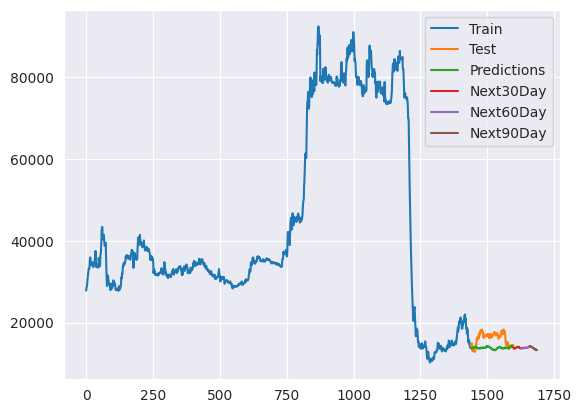

In [47]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred)
plt.plot(last_data1,y_next_90_days[0:30])
plt.plot(last_data2,y_next_90_days[31:60])
plt.plot(last_data3,y_next_90_days[61:90])
plt.legend(['Train', 'Test', 'Predictions','Next30Day', 'Next60Day', 'Next90Day'])
plt.show()